# 실험실 설명
- 환경 수정
    - for문 최소화, numpy.array 기능 활용
- 신경망 수정
    - 배치 정규화
    - 배치 사이즈 = 64
- lr 수정
    - scheduler 삭제
- reward_dict = {'mine':-1, 'empty':1, 'overlapped':-1, 'guess':0.3, 'clear':1}
- epsilon min = 0.01
- count 제한: 81

In [ ]:
import time
import os
import pickle
import numpy as np
import pandas as pd
from typing import Tuple
from collections import deque
import copy
from scipy.special import softmax
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/AI폭탄제거부대/sseung')
print(os.getcwd())

/content/drive/MyDrive/AI폭탄제거부대/sseung


# 시각화 함수

In [ ]:
def visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(3, 4, figsize=(20, 15), squeeze=False)
    axs[0, 0].plot(df['ave_rewards'], color = 'blue')
    axs[0, 0].set_title("Avg Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['ave_count'], color = 'skyblue')
    axs[1, 0].set_title("Avg Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[2, 0].plot(df['ave_loss'], color = 'green')
    axs[2, 0].set_title("Avg Loss")
    axs[2, 1].plot(df['mid_loss'], color = 'green')
    axs[2, 1].set_title("Median Loss")
    axs[2, 2].plot(df['loss'], color = 'green')
    axs[2, 2].set_title('Loss')

    axs[0, 3].plot(df['ave_clear'], color = 'red')
    axs[0, 3].set_title("Avg Clear")
    axs[1, 3].plot(df['lr'], color = 'grey')
    axs[1, 3].set_title("Learning Rate")

    plt.show()

In [ ]:
def test_visualizing(file):
    with open(file, 'rb') as f:
        df = pickle.load(f)

    fig, axs = plt.subplots(2, 4, figsize=(20, 10), squeeze=False)
    axs[0, 0].plot(df['avg_rewards'], color = 'blue')
    axs[0, 0].set_title("Avg Reward")
    axs[0, 1].plot(df['mid_rewards'], color = 'blue')
    axs[0, 1].set_title("Median Reward")
    axs[0, 2].plot(df['rewards'], color = 'blue')
    axs[0, 2].set_title("Reward")

    axs[1, 0].plot(df['avg_count'], color = 'skyblue')
    axs[1, 0].set_title("Avg Cnt")
    axs[1, 1].plot(df['mid_count'], color = 'skyblue')
    axs[1, 1].set_title("Median Cnt")
    axs[1, 2].plot(df['cnt'], color = 'skyblue')
    axs[1, 2].set_title("Cnt")

    axs[0, 3].plot(df['avg_clear'], color = 'red')
    axs[0, 3].set_title("Avg Clear")

    plt.show()

# 환경

In [ ]:
class Environment:
    def __init__(self, gridworld_size:Tuple, num_mine:int):

        self.gridworld_size = gridworld_size
        self.nrow, self.ncol = self.gridworld_size
        self.num_mine = num_mine

        # 그리드월드의 좌표(튜플)의 리스트
        # points == action space
        self.points = np.arange(self.nrow * self.ncol)
        self.num_actions = len(self.points)

        # reward, done 딕셔너리
        self.reward_dict = {'mine':-1, 'empty':1, 'overlapped':-1, 'guess':0.3, 'clear':1}
        self.done_dict = {'mine':True, 'empty':False, 'overlapped':False, 'guess':False, 'clear':True}

        # 지뢰 랜덤으로 배정
        self.mine_points = np.random.choice(self.points, self.num_mine, replace=False)

        # 정답 맵
        self.map_answer, self.mine_bool = self.make_answer_map()

        # state 맵
        self.present_state = np.full((self.nrow, self.ncol), -1) # BFS로 탐색하지 않은 부분을 -1로 초기화


    def make_answer_map(self):
        answer_map = np.full(shape=(self.nrow, self.ncol), fill_value=0)
        x, y = np.divmod(self.mine_points, self.ncol)
        answer_map[x, y] = -2
        mine_bool = (answer_map==-2)

        directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

        for idx in self.points:
            if idx in self.mine_points:
                continue
            else:
                x, y = divmod(idx, self.ncol)
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.nrow and 0 <= ny < self.ncol:
                        if mine_bool[nx, ny]:
                            answer_map[x, y] += 1

        return answer_map, mine_bool



    def bfs_minesweeper(self, clicked_idx:int):
        '''
        input : 클릭할 idx
        output : 클릭한 좌표에 따라서 열린 맵(array)
        가려져있는 맵에서 클릭할 좌표에 따라 맵을 열어주는 함수
        '''
        act_x, act_y = divmod(clicked_idx, self.ncol)
        queue = deque([(act_x, act_y)])
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, -1), (-1, 1), (1, -1), (1, 1)]

        result = self.present_state.copy()

        while queue:
            x, y = queue.popleft()

            if result[x, y] != -1:
                continue

            result[x, y] = self.map_answer[x, y]

            if self.map_answer[x,y] == 0:
                for dx, dy in directions:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.nrow and 0 <= ny < self.ncol and result[nx, ny] == -1:
                        queue.append((nx,ny)) # 좌표 -> 인덱스 역산

        return result


    def check_guess(self, clicked_idx:int):
        '''
        input : clicked_idx(클릭한 좌표)
        output : 해당 좌표가 guess인지 (bool)
        클릭한 좌표가 guess인지 확인하는 함수
        클릭한 좌표 주변 8칸이 모두 열리지 않은 경우 guess
        '''
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]
        x, y = divmod(clicked_idx, self.ncol)
        result = 0

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.nrow and 0 <= ny < self.ncol:
                if self.present_state[nx, ny] == -1:
                    result += 1

        if result == 8:
            return True
        else:
            return False


    def move_mine(self, action_idx:int):
        '''
        에이전트가 첫 번째로 선택한 action이 지뢰인 경우
        해당 좌표의 지뢰를 다른 곳으로 옮기는 함수
        - input : action_idx - 좌표
        '''
        empty_points = np.setdiff1d(self.points, self.mine_points)
        new_mine = np.random.choice(empty_points, 1)

        self.mine_points = np.delete(self.mine_points, np.where(self.mine_points == action_idx))
        self.mine_points = np.append(self.mine_points, new_mine[0])

        # 정답 맵
        self.map_answer, self.mine_bool = self.make_answer_map()
        # state 맵
        self.present_state = np.full((self.nrow, self.ncol), -1)


    def step(self, action_idx:int):
        '''
        에이전트가 선택한 action에 따라 주어지는 next_state, reward, done
        - input : action_idx - 좌표
        - output : next_state, reward, done, clear
        '''
        x, y = divmod(action_idx, self.ncol)

        # 첫번째 action인 경우
        if np.sum(self.present_state != -1) == 0 :
            if action_idx in self.mine_points:
                # 만약 start 좌표에 지뢰가 있는 경우 옮기기
                self.move_mine(action_idx)


        # action에 따라 계산된 state
        next_state = self.bfs_minesweeper(action_idx)

        # ======
        # reward
        if action_idx in self.mine_points:
            # 지뢰
            reward = self.reward_dict['mine']
            done = self.done_dict['mine']
            clear = False

        elif np.sum(next_state == -1) == self.num_mine:
            # 클리어
            reward = self.reward_dict['clear']
            done = self.done_dict['clear']
            clear = True

        else :
            clear = False
            guess = self.check_guess(action_idx)

            if self.present_state[x,y] != -1:
                # 중복 행동
                reward = self.reward_dict['overlapped']
                done = self.done_dict['overlapped']

            elif guess:
                # 추측 행동
                reward = self.reward_dict['guess']
                done = self.done_dict['guess']

            else:
                # 좋은 행동
                reward = self.reward_dict['empty']
                done = self.done_dict['empty']

        # 현재 state 업데이트
        self.present_state = next_state

        return next_state, reward, done, clear


    def reset(self):
        # 지뢰 랜덤으로 배정
        self.mine_points = np.random.choice(self.points, self.num_mine, replace=False)
        # 정답 맵
        self.map_answer, self.mine_bool = self.make_answer_map()
        # state 맵
        self.present_state = np.full((self.nrow, self.ncol), -1) # BFS로 탐색하지 않은 부분을 -1로 초기화


    def render(self, state):
        render_state = np.full(shape=(self.nrow, self.ncol), fill_value=".")

        for idx in self.points:
            x, y = divmod(idx, self.ncol)
            if state[x,y] == -1:
                continue
            elif state[x,y] == -2:
                render_state[x,y] = "M"
            else:
                render_state[x,y] = state[x,y]

        render_state = pd.DataFrame(render_state)
        render_state = render_state.style.applymap(self.render_color)
        display(render_state)


    def render_answer(self):
        render_state = np.full(shape=(self.nrow, self.ncol), fill_value=".")

        for idx in self.points:
            x, y = divmod(idx, self.ncol)
            if self.map_answer[x,y] == -2:
                render_state[x,y] = "M"
            else:
                render_state[x,y] = str(self.map_answer[x,y])

        render_state = pd.DataFrame(render_state)
        render_state = render_state.style.applymap(self.render_color)
        display(render_state)


    def render_color(self, var):
        color = {'0':'black', '1':"skyblue", '2':'lightgreen', '3':'red', '4':'violet', '5':'brown',
                 '6':'turquoise', '7':'grey', '8':'black', 'M':'white', '.':'black'}
        return f"color: {color[var]}"


    def samples(self, num:int):
        sample_mine_points = []

        for i in range(num):
            self.mine_points = np.random.choice(self.points, self.num_mine, replace=False)
            sample_mine_points.append(self.mine_points)

        return sample_mine_points

    def train_reset(self, samples:np.array):
        self.mine_points = random.sample(samples, 1)[0]
        # 정답 맵
        self.map_answer, self.mine_bool = self.make_answer_map()
        # state 맵
        self.present_state = np.full((self.nrow, self.ncol), -1) # BFS로 탐색하지 않은 부분을 -1로 초기화


    def check_18_up(self, state):
        if np.sum(state != -1) >= 18:
            return True
        else:
            return False


# DQN 신경망

In [ ]:
class DQN_Net(nn.Module):
    def __init__(self, state_size, action_size, conv_units):
        super().__init__()
        # 합성곱 층 정의
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=2)

        self.conv2 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_units)

        self.conv3 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)
        self.bn3 = nn.BatchNorm2d(conv_units)

        self.conv4 = nn.Conv2d(in_channels=conv_units, out_channels=conv_units, kernel_size=(3,3), bias=False, padding=1)

        self.fc_size = conv_units * (state_size[-1]+2) * (state_size[-2]+2)
        self.fc = nn.Linear(self.fc_size, action_size)

    def forward(self, x):
        # 순전파
        x = F.relu(self.conv1(x))  # 첫 번째 합성곱층과 활성화 함수 적용 후 풀링
        x = F.relu(self.bn2(self.conv2(x)))  # 두 번째 합성곱층과 활성화 함수 적용
        x = F.relu(self.bn3(self.conv3(x)))  # 세 번째 합성곱층과 활성화 함수 적용
        x = F.relu(self.conv4(x))  # 네 번째 합성곱층과 활성화 함수 적용

        # flatten
        x = x.view(-1, self.fc_size)  # 배치 크기에 맞게 데이터를 평탄화
        # 완전 연결층
        x = self.fc(x)

        return x

# 에이전트 - no rule

In [ ]:
class DQN_Agent:
    def __init__(self, state_size:Tuple, action, num_mine):
        self.num_mine=num_mine
        self.state_size = state_size # 튜플로 입력받음
        self.action = torch.tensor(action)
        self.q_values = torch.zeros(self.action.shape, dtype=torch.float32)

        # 하이퍼파라미터
        self.epsilon = EPSILON
        self.epsilon_decay = EPSILON_DECAY
        self.epsilon_min = EPSILON_MIN
        self.batch_size = BATCH_SIZE
        self.gamma = GAMMA

        # 추가
        self.nrow = state_size[0]
        self.ncol = state_size[1]
        self.n = self.nrow*self.ncol

        # 리플레이 메모리
        self.memory = deque(maxlen = MEM_SIZE)

        # 모델과 타깃 모델 생성
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # model, target model gpu 올리고 초기화
        self.model = DQN_Net(state_size, len(action), CONV_UNITS).to(self.device)
        self.target_model = DQN_Net(state_size, len(action), CONV_UNITS).to(self.device)
        self.update_target_model()
        self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARN_MAX)


    def update_target_model(self):
        # 타깃 모델을 업데이트 하는 함수
        self.target_model.load_state_dict(self.model.state_dict())


    def append_sample(self, state, action, reward, next_state, done, clear):
        # 샘플을 리플레이 메모리에 저장하는 함수
        self.memory.append((state, action, reward, next_state, done, clear))


    def get_action(self, state):

        state=torch.tensor(state).to(self.device)

        if np.random.rand() <= self.epsilon:  # 무작위 탐색
            act = random.choice(self.action)

        else :
            state = state.unsqueeze(0).to(dtype = torch.float32)
            state = state.unsqueeze(0)
            # 정규화
            state = state/8

            with torch.no_grad():
                q_values = self.model(state).flatten().to("cpu")
                max_idx = torch.argmax(q_values)
                act = max_idx.item()

                self.q_values = q_values

        return act


    def train_model(self):
        #리플레이 메모리에서 무작위로 추출한 배치로 모델 학습

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        # 상태 정규화 포함
        states = torch.tensor([sample[0]/8 for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        actions = torch.tensor([sample[1] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)
        rewards = torch.tensor([sample[2] for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1)
        next_states = torch.tensor([sample[3]/8 for sample in mini_batch], dtype=torch.float32).to(self.device).reshape(-1,1,self.nrow,self.ncol)
        dones = torch.tensor([sample[4] for sample in mini_batch], dtype=torch.long).to(self.device).reshape(-1,1)  # bool로 변경
        clears = torch.tensor([sample[5] for sample in mini_batch], dtype=torch.bool).reshape(-1,1)  # bool로 변경

        # 현재 상태에 대한 모델의 큐함수
        predicts = self.model(states) # 현재 상태의 좌표를 준다
        one_hot_action= F.one_hot(actions, self.n).to(self.device)
        predicts = torch.sum(one_hot_action*predicts, axis=1)

         # Q(s,a) 값을 예측값으로 사용 - (batch, action_space.n)
        pred_q_values = self.model(states).gather(1, actions) # action idx의 데이터만 꺼냄

        # target 값 계산 : reward + gamma * Q(s',a')
        with torch.no_grad():
            next_q_values = self.target_model(next_states).max(1).values.reshape(-1,1)
            target_q_values = rewards + (torch.ones(next_q_values.shape, device=self.device) - dones) * self.gamma * next_q_values

        # 오류 함수를 줄이는 방향으로 모델 업데이트
        loss = F.mse_loss(pred_q_values, target_q_values)

        self.optimizer.zero_grad() # 반복 때마다 기울기를 새로 계산해야하므로 기울기 초기화
        loss.backward() # 역전파 알고리즘 계산
        self.optimizer.step() # 계산한 기울기를 adam 알고리즘에 맞추어 가중치를 수정

        # 엡실론
        self.epsilon = self.epsilon*self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)

        return loss

# 테스트

In [ ]:
# 하이퍼 파라미터
MEM_SIZE = 50000
MEM_SIZE_MIN = 1000

REWARD_MEM_SIZE = 20000
REWARD_MEM_SIZE_MIN = 500

BATCH_SIZE = 64
BATCH_RATE = 0

LEARN_MAX = 0.001 # 스케줄러 (learning rate 감소 모듈) 사용
LEARN_MIN = 0.0001
LEARN_DECAY = 0.5
LEARN_EPOCH = 50000

GAMMA = 0.1 #gamma

EPSILON = 0
EPSILON_DECAY = 0.99995
EPSILON_MIN = 0

# DQN settings
CONV_UNITS = 64
UPDATE_TARGET_EVERY = 5

grid_size = (9, 9)
num_mines = 10

PRINT_EVERY = 100
SAVE_EVERY = 100

EPISODES = 10000

In [ ]:
with open('experiment8_model_3.pkl', 'rb') as f:
    model_param = pickle.load(f)
################################
env = Environment(grid_size, num_mines)
agent = DQN_Agent(grid_size, env.points, num_mines)

agent.model.load_state_dict(model_param)
agent.target_model.load_state_dict(model_param)
agent.epsilon = 0

rewards_list = []
clear_list = []
cnt_list = []

avg_rewards_list = []
avg_clear_list = []
avg_count_list = []

mid_rewards_list = []
mid_clear_list = []
mid_cnt_list = []

for episode in range(EPISODES):
    # reset
    env.reset()
    state = env.present_state.copy()
    done = False
    clear = False
    total_reward = 0
    cnt = 0
    loss = 0
    agent.action = env.points.copy()

    # 게임 종료까지 반복
    while not done:
        cnt+=1

        state = env.present_state.copy()
        action = agent.get_action(state)
        next_state, reward, done, clear = env.step(action)
        total_reward += reward

        # count 제한: 100
        if cnt > 81:
            done = True

        if done or clear:
            break

    # 평가지표
    rewards_list.append(total_reward)
    avg_rewards_list.append(np.mean(rewards_list[-PRINT_EVERY:]))
    mid_rewards_list.append(np.median(rewards_list[-PRINT_EVERY:]))

    clear_list.append(clear)
    avg_clear_list.append(np.mean(clear_list[-PRINT_EVERY:]))
    mid_clear_list.append(np.median(clear_list[-PRINT_EVERY:]))

    cnt_list.append(cnt)
    avg_count_list.append(np.mean(cnt_list[-PRINT_EVERY:]))
    mid_cnt_list.append(np.median(cnt_list[-PRINT_EVERY:]))

    if ((episode+1) % SAVE_EVERY == 0) or episode+1 == EPISODES:
        # 시각화 저장
        df = pd.DataFrame()
        df['rewards'] = rewards_list
        df['avg_rewards'] = avg_rewards_list
        df['mid_rewards'] = mid_rewards_list
        df['clear'] = clear_list
        df['avg_clear'] = avg_clear_list
        df['mid_clear'] = mid_clear_list
        df['cnt'] = cnt_list
        df['avg_count'] = avg_count_list
        df['mid_count'] = mid_cnt_list

        with open('experiment8_visualizing_test2.pkl', 'wb') as f:
            pickle.dump(df, f)


    if (episode+1) % PRINT_EVERY == 0:
        print(f"[{episode+1}/{EPISODES}]", end=" | ")
        print(f"avg clear: {round(np.mean(clear_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"cnt: {round(np.mean(cnt_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(cnt_list[-PRINT_EVERY*10:]), 3)}", end=" | ")
        print(f"Reward: {round(np.mean(rewards_list[-PRINT_EVERY*10:]), 3)}/{round(np.median(rewards_list[-PRINT_EVERY*10:]), 3)}", end="\n")
        env.render(env.present_state)

print(f"Test completed. avg win rate: {round(np.mean(clear_list), 3)}")

[100/10000] | avg clear: 0.63 | cnt: 16.04/16.0 | Reward: 13.92/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,M,.,1,0,0
1,.,.,.,.,.,.,1,1,1
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[200/10000] | avg clear: 0.65 | cnt: 15.56/16.0 | Reward: 14.167/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[300/10000] | avg clear: 0.653 | cnt: 15.49/16.0 | Reward: 14.334/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,M,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,1,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[400/10000] | avg clear: 0.658 | cnt: 15.41/16.0 | Reward: 14.378/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,1,2,.,1,.
1,M,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,1,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,1,.,.,.


[500/10000] | avg clear: 0.664 | cnt: 15.562/16.0 | Reward: 14.61/16.0


,0,1,2,3,4,5,6,7,8
0,1,2,.,.,1,1,1,1,.
1,.,.,3,.,M,.,.,.,.
2,1,2,.,.,.,.,.,.,.
3,0,1,.,3,.,.,.,.,.
4,0,1,1,2,.,.,.,.,.
5,0,0,0,1,.,.,.,.,.
6,0,0,0,1,.,.,.,.,.
7,0,0,0,1,.,.,.,.,.
8,0,0,0,1,.,.,.,.,.


[600/10000] | avg clear: 0.672 | cnt: 15.65/16.0 | Reward: 14.759/16.0


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,1,.,1,0,0
1,.,1,0,0,1,1,1,0,0
2,1,2,2,2,1,0,0,0,0
3,1,2,.,.,2,2,1,1,0
4,.,M,3,4,.,3,.,1,0
5,.,1,.,.,.,.,2,1,0
6,.,.,.,.,.,.,1,0,0
7,.,.,.,.,.,2,2,0,0
8,.,.,.,.,.,.,1,0,0


[700/10000] | avg clear: 0.673 | cnt: 15.677/16.0 | Reward: 14.413/16.0


,0,1,2,3,4,5,6,7,8
0,1,.,1,1,.,1,0,0,0
1,1,1,1,1,1,1,0,0,0
2,0,0,0,1,1,1,0,0,0
3,0,0,0,2,.,3,1,1,0
4,0,0,1,3,.,3,.,1,0
5,0,0,2,.,3,2,1,1,0
6,0,0,2,.,2,0,1,2,2
7,0,0,2,2,2,0,1,.,.
8,0,0,1,.,1,0,1,2,2


[800/10000] | avg clear: 0.678 | cnt: 15.689/16.0 | Reward: 14.509/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,1,0,0,0
1,0,0,0,1,1,2,1,1,0
2,1,1,0,0,1,2,.,2,1
3,.,2,1,1,2,.,4,.,1
4,1,3,.,2,2,.,3,1,1
5,0,3,.,3,1,2,2,1,0
6,0,2,.,2,0,1,.,1,0
7,0,1,1,1,0,1,1,1,0
8,0,0,0,0,0,0,0,0,0


[900/10000] | avg clear: 0.679 | cnt: 15.667/16.0 | Reward: 14.548/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,1,1,2,.
1,0,0,1,2,2,3,.,3,1
2,0,1,1,2,.,3,.,2,0
3,0,1,.,2,1,2,1,1,0
4,0,1,1,1,1,1,1,0,0
5,0,0,0,0,1,.,1,1,1
6,0,0,0,1,2,2,1,1,.
7,0,1,1,2,.,1,0,1,1
8,0,1,.,2,1,1,0,0,0


[1000/10000] | avg clear: 0.676 | cnt: 15.647/16.0 | Reward: 14.567/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,0,1,1
1,0,1,3,3,2,0,0,1,.
2,0,2,.,.,1,0,0,1,1
3,1,3,.,3,1,0,0,1,1
4,1,.,2,1,0,0,1,2,.
5,1,1,1,0,0,0,1,.,2
6,0,0,0,0,0,0,1,1,1
7,0,1,2,2,1,0,0,0,0
8,0,1,.,.,1,0,0,0,0


[1100/10000] | avg clear: 0.687 | cnt: 15.678/16.0 | Reward: 14.756/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,2,1,1,0
1,0,0,0,1,1,2,.,1,0
2,0,0,0,0,1,2,2,2,1
3,0,1,1,1,1,.,1,2,.
4,0,1,.,1,1,1,1,2,.
5,0,2,2,2,0,1,1,2,1
6,0,1,.,2,1,1,.,1,0
7,0,1,3,.,2,1,1,1,0
8,0,0,2,.,2,0,0,0,0


[1200/10000] | avg clear: 0.691 | cnt: 15.752/16.0 | Reward: 14.838/16.0


,0,1,2,3,4,5,6,7,8
0,1,.,.,2,1,0,1,1,1
1,1,3,4,.,1,0,1,.,1
2,0,1,.,3,2,0,1,1,1
3,0,1,2,.,1,0,0,0,0
4,0,0,2,2,2,0,0,0,0
5,0,0,1,.,2,1,1,0,0
6,0,0,1,1,2,.,2,1,0
7,0,1,1,1,1,2,.,1,0
8,0,1,.,1,0,1,1,1,0


[1300/10000] | avg clear: 0.698 | cnt: 15.977/17.0 | Reward: 15.075/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[1400/10000] | avg clear: 0.696 | cnt: 16.067/17.0 | Reward: 15.159/16.5


,0,1,2,3,4,5,6,7,8
0,.,1,1,1,0,0,0,0,0
1,.,.,.,2,1,1,1,0,0
2,.,.,.,2,1,.,1,0,0
3,.,2,1,1,1,1,1,0,0
4,.,1,0,0,0,0,0,0,0
5,.,2,1,1,0,0,0,0,0
6,.,.,.,1,1,1,2,2,2
7,M,.,2,.,1,.,2,.,.
8,.,.,.,.,.,.,.,2,2


[1500/10000] | avg clear: 0.697 | cnt: 15.995/17.0 | Reward: 15.089/17.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,1,.,1,0,0
1,1,2,1,2,3,3,2,0,0
2,0,1,.,2,.,.,1,0,0
3,0,1,1,2,2,2,1,0,0
4,1,1,1,1,2,1,1,0,0
5,.,1,1,.,2,.,1,0,0
6,1,1,1,1,3,2,2,1,1
7,0,0,0,0,1,.,1,1,.
8,0,0,0,0,1,1,1,1,1


[1600/10000] | avg clear: 0.704 | cnt: 16.141/17.0 | Reward: 15.25/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[1700/10000] | avg clear: 0.706 | cnt: 16.115/17.0 | Reward: 15.512/17.0


,0,1,2,3,4,5,6,7,8
0,1,1,1,0,1,.,1,0,0
1,2,.,1,0,1,2,2,1,0
2,.,2,1,0,0,1,.,1,0
3,1,2,1,1,0,1,1,1,0
4,0,1,.,1,0,0,0,0,0
5,1,2,3,2,1,0,1,1,1
6,2,.,2,.,1,0,1,.,1
7,.,2,2,1,1,1,2,2,1
8,1,1,0,0,0,1,.,1,0


[1800/10000] | avg clear: 0.708 | cnt: 16.212/17.0 | Reward: 15.613/17.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,0,0,0,1,.
1,1,2,3,3,2,1,1,2,2
2,1,.,2,.,.,1,1,.,1
3,1,1,2,2,2,1,1,1,1
4,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,2,2,1
6,0,0,0,0,0,1,.,.,1
7,0,0,1,1,1,1,3,3,2
8,0,0,1,.,1,0,1,.,1


[1900/10000] | avg clear: 0.708 | cnt: 16.17/17.0 | Reward: 15.571/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,1,0,0,0,0,0
1,.,M,.,2,1,0,0,0,0
2,1,1,2,.,1,0,0,0,0
3,0,0,1,1,2,1,1,1,1
4,0,0,0,0,1,.,2,.,.
5,1,1,1,0,1,2,.,.,.
6,1,.,2,1,0,1,2,.,.
7,.,2,.,1,0,0,1,.,.
8,.,1,1,1,0,0,1,.,.


[2000/10000] | avg clear: 0.716 | cnt: 16.267/17.0 | Reward: 15.686/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,2,1,1,1,1
1,2,2,2,2,.,2,2,.,1
2,.,.,1,1,2,.,2,1,1
3,2,3,2,1,1,1,2,1,1
4,0,1,.,1,0,0,1,.,1
5,0,1,1,1,0,1,2,2,1
6,0,0,0,0,0,2,.,2,0
7,0,0,0,0,0,2,.,2,0
8,0,0,0,0,0,1,1,1,0


[2100/10000] | avg clear: 0.715 | cnt: 16.322/17.0 | Reward: 15.598/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0
2,0,1,.,1,1,1,1,1,1
3,0,1,1,1,1,.,2,2,.
4,0,0,0,0,1,1,2,.,3
5,1,1,1,0,0,1,3,4,.
6,1,.,1,1,2,3,.,.,2
7,1,1,1,1,.,.,3,2,1
8,0,0,0,1,2,2,1,0,0


[2200/10000] | avg clear: 0.711 | cnt: 16.262/17.0 | Reward: 15.529/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,2,1,0,0
1,0,0,0,1,2,.,1,0,0
2,0,1,2,2,2,1,1,1,1
3,1,3,.,.,1,0,0,1,.
4,.,3,.,3,1,0,0,1,1
5,2,3,1,1,0,0,0,0,0
6,.,1,0,0,0,0,0,1,1
7,1,1,0,0,0,1,1,2,.
8,0,0,0,0,0,1,.,2,1


[2300/10000] | avg clear: 0.713 | cnt: 16.076/17.0 | Reward: 15.347/17.0


,0,1,2,3,4,5,6,7,8
0,0,1,2,2,1,0,0,0,0
1,0,1,.,.,1,0,0,0,0
2,0,1,2,2,1,0,0,1,1
3,0,0,0,0,0,0,0,1,.
4,1,1,1,1,1,1,1,2,1
5,.,1,1,.,1,1,.,1,0
6,2,2,3,2,2,1,1,1,0
7,2,.,4,.,1,0,0,0,0
8,2,.,.,2,1,0,0,0,0


[2400/10000] | avg clear: 0.724 | cnt: 16.123/17.0 | Reward: 15.417/16.5


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,1,1,2,.
1,1,1,2,1,2,.,1,2,.
2,1,.,2,.,2,1,1,1,1
3,1,1,2,1,2,1,2,1,1
4,0,0,0,0,1,.,2,.,1
5,0,0,0,1,2,2,3,2,2
6,0,0,0,1,.,1,1,.,1
7,0,0,0,1,1,1,2,2,2
8,0,0,0,0,0,0,1,.,1


[2500/10000] | avg clear: 0.72 | cnt: 16.049/17.0 | Reward: 15.336/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,0,1,.
1,0,0,2,2,2,0,0,1,1
2,0,1,2,.,1,1,2,2,1
3,0,1,.,4,3,2,.,.,1
4,0,1,2,.,.,2,2,2,1
5,0,0,1,2,2,1,0,0,0
6,1,1,1,0,0,0,0,0,0
7,1,.,1,0,0,1,1,1,0
8,1,1,1,0,0,1,.,1,0


[2600/10000] | avg clear: 0.709 | cnt: 15.765/16.0 | Reward: 15.03/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,1,1,1,0,0
1,0,1,1,2,2,.,1,0,0
2,0,0,0,1,.,3,2,0,0
3,1,1,1,1,2,.,1,1,1
4,1,.,2,1,2,3,3,2,.
5,1,2,.,1,1,.,.,2,1
6,0,1,1,2,2,3,2,1,0
7,0,0,0,1,.,1,0,0,0
8,0,0,0,1,1,1,0,0,0


[2700/10000] | avg clear: 0.708 | cnt: 15.845/16.0 | Reward: 14.981/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,1,2,.
1,0,0,0,0,0,2,.,3,1
2,0,0,0,0,0,2,.,2,0
3,0,1,2,2,1,2,2,2,0
4,0,1,.,.,1,1,.,2,1
5,0,2,3,3,1,1,3,.,2
6,0,1,.,1,0,1,3,.,2
7,0,1,1,1,0,1,.,2,1
8,0,0,0,0,0,1,1,1,0


[2800/10000] | avg clear: 0.698 | cnt: 15.81/16.0 | Reward: 14.792/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,1,.,1
2,0,0,0,1,1,1,1,1,1
3,0,1,1,2,.,1,1,1,1
4,0,1,.,2,1,1,1,.,1
5,1,2,2,2,2,2,2,1,1
6,1,.,2,2,.,.,1,0,0
7,2,3,3,.,3,2,1,0,0
8,.,2,.,2,1,0,0,0,0


[2900/10000] | avg clear: 0.698 | cnt: 15.93/16.0 | Reward: 14.911/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,1,1,0,0,0,1,1
1,0,1,.,1,0,0,0,1,.
2,2,3,2,1,0,0,0,2,2
3,.,.,1,0,0,1,1,2,.
4,3,3,1,0,0,2,.,3,1
5,.,1,0,0,0,2,.,2,0
6,1,1,0,0,0,1,1,1,0
7,0,0,0,0,1,1,2,1,1
8,0,0,0,0,1,.,2,.,1


[3000/10000] | avg clear: 0.699 | cnt: 15.894/16.0 | Reward: 14.878/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,1,0,0
1,.,.,.,.,.,.,2,1,0
2,.,.,.,.,.,3,.,2,0
3,.,.,.,.,.,.,.,2,0
4,.,.,.,.,.,M,2,2,1
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[3100/10000] | avg clear: 0.692 | cnt: 15.753/16.0 | Reward: 14.867/16.0


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,0,0
1,.,1,0,1,1,1,0,0,0
2,2,2,0,1,.,2,1,1,0
3,.,1,0,1,1,2,.,2,1
4,2,2,1,0,0,2,3,.,1
5,2,.,1,1,1,2,.,2,1
6,.,2,1,1,.,2,1,1,0
7,2,2,0,1,1,1,0,0,0
8,.,1,0,0,0,0,0,0,0


[3200/10000] | avg clear: 0.697 | cnt: 15.928/17.0 | Reward: 14.906/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,1,0,0,0,0,0,0
1,.,.,2,0,0,0,0,1,1
2,.,.,2,1,2,1,1,1,.
3,.,.,2,.,.,.,.,2,1
4,.,.,.,.,.,.,M,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[3300/10000] | avg clear: 0.693 | cnt: 15.88/17.0 | Reward: 14.851/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,M,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,2,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[3400/10000] | avg clear: 0.687 | cnt: 15.826/17.0 | Reward: 14.784/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,0,0
1,2,2,1,0,0,0,1,2,2
2,1,.,1,0,0,0,2,.,.
3,1,1,1,0,0,0,2,.,3
4,0,0,0,0,0,0,1,1,1
5,0,0,0,0,1,1,2,2,2
6,0,0,0,0,1,.,2,.,.
7,0,0,0,1,2,3,3,3,2
8,0,0,0,1,.,2,.,1,0


[3500/10000] | avg clear: 0.693 | cnt: 15.964/17.0 | Reward: 14.932/16.65


,0,1,2,3,4,5,6,7,8
0,1,2,.,1,0,0,0,1,.
1,1,.,2,1,0,0,0,1,1
2,1,1,1,1,2,2,1,0,0
3,0,0,0,2,.,.,1,0,0
4,0,0,0,2,.,3,1,1,1
5,0,0,0,1,2,2,1,1,.
6,1,2,2,1,1,.,1,1,1
7,1,.,.,1,1,1,1,0,0
8,1,2,2,1,0,0,0,0,0


[3600/10000] | avg clear: 0.69 | cnt: 15.974/17.0 | Reward: 14.935/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,2,1,1,0,1,.
1,0,1,1,2,.,1,0,1,.
2,0,0,1,2,2,1,0,1,1
3,0,0,1,.,1,0,0,1,.
4,0,0,1,1,1,0,0,1,.
5,0,0,0,0,0,0,1,2,.
6,0,0,0,1,1,1,1,.,.
7,1,1,0,1,.,1,2,.,.
8,.,1,0,1,1,1,1,.,M


[3700/10000] | avg clear: 0.691 | cnt: 15.824/17.0 | Reward: 14.914/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,2,.,1,0,0,0
1,1,1,2,.,3,2,0,0,0
2,3,.,3,2,.,1,0,0,0
3,.,.,2,1,1,1,0,1,1
4,2,2,2,1,2,2,2,2,.
5,0,0,1,.,2,.,.,2,1
6,0,0,1,1,2,2,2,1,0
7,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0


[3800/10000] | avg clear: 0.693 | cnt: 15.702/16.0 | Reward: 14.93/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,M,.,.,1,0,0
1,.,.,.,.,.,.,1,0,0
2,.,.,.,.,.,.,1,0,0
3,.,.,.,.,.,.,1,1,1
4,.,.,.,.,.,.,1,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,.,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[3900/10000] | avg clear: 0.692 | cnt: 15.685/16.0 | Reward: 14.911/16.0


,0,1,2,3,4,5,6,7,8
0,1,2,.,1,0,0,0,0,0
1,1,.,2,1,0,0,0,0,0
2,1,1,1,1,1,2,1,1,0
3,0,0,0,2,.,3,.,1,0
4,0,0,1,4,.,4,2,2,1
5,0,0,1,.,.,2,1,.,1
6,0,0,1,2,2,1,1,1,1
7,1,2,1,1,0,0,0,0,0
8,.,2,.,1,0,0,0,0,0


[4000/10000] | avg clear: 0.684 | cnt: 15.608/16.0 | Reward: 14.817/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,2,1,0,0,0
1,0,0,2,3,.,1,0,1,1
2,1,1,1,.,2,2,1,2,.
3,.,1,1,1,1,1,.,2,1
4,1,1,0,0,0,1,1,2,1
5,1,2,2,1,0,0,0,1,.
6,2,.,.,1,0,0,0,1,1
7,2,.,3,1,0,0,0,0,0
8,1,1,1,0,0,0,0,0,0


[4100/10000] | avg clear: 0.688 | cnt: 15.636/16.0 | Reward: 14.853/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,2,.,3,.
1,0,0,0,0,1,.,2,3,.
2,0,1,1,1,1,1,1,1,1
3,0,1,.,1,0,0,0,0,0
4,0,1,1,2,1,2,1,1,0
5,0,1,1,2,.,2,.,1,0
6,1,2,.,2,1,2,1,1,0
7,.,3,1,1,0,0,0,0,0
8,.,2,0,0,0,0,0,0,0


[4200/10000] | avg clear: 0.687 | cnt: 15.538/16.0 | Reward: 14.901/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,2,1,1,0
1,0,0,0,1,1,2,.,1,0
2,1,1,0,0,0,1,1,1,0
3,.,2,1,1,1,1,1,0,0
4,2,3,.,1,1,.,1,0,0
5,.,3,2,1,1,1,1,0,0
6,2,.,1,0,0,1,1,1,0
7,1,2,2,1,0,2,.,2,0
8,0,1,.,1,0,2,.,2,0


[4300/10000] | avg clear: 0.693 | cnt: 15.657/16.0 | Reward: 15.032/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,1,1,0,0,0,0,0
1,0,1,.,1,0,0,0,1,1
2,1,3,3,2,0,0,0,1,.
3,2,.,.,1,0,0,1,2,2
4,3,.,4,1,0,0,1,.,1
5,3,.,3,0,0,0,1,1,1
6,2,.,3,1,1,0,0,0,0
7,1,1,2,.,1,0,1,1,1
8,0,0,1,1,1,0,1,.,1


[4400/10000] | avg clear: 0.686 | cnt: 15.719/16.0 | Reward: 14.956/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,1,0,1,.
1,0,0,1,2,2,1,0,1,1
2,1,1,2,.,1,0,0,0,0
3,1,.,2,1,1,0,0,0,0
4,1,1,1,0,0,0,1,1,1
5,0,0,0,0,0,0,1,.,1
6,0,0,1,1,1,1,3,3,2
7,0,0,2,.,3,2,.,.,1
8,0,0,2,.,3,.,3,2,1


[4500/10000] | avg clear: 0.679 | cnt: 15.589/16.0 | Reward: 14.814/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,2,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[4600/10000] | avg clear: 0.686 | cnt: 15.691/16.0 | Reward: 14.931/16.0


,0,1,2,3,4,5,6,7,8
0,1,1,0,0,0,0,0,0,0
1,.,1,0,0,0,0,0,0,0
2,2,2,0,0,0,1,1,1,0
3,.,3,2,2,1,1,.,1,0
4,.,3,.,.,2,2,1,1,0
5,1,2,2,3,.,1,0,0,0
6,0,0,0,2,2,3,1,2,1
7,0,0,0,1,.,2,.,2,.
8,0,0,0,1,1,2,1,2,1


[4700/10000] | avg clear: 0.681 | cnt: 15.658/16.0 | Reward: 14.888/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,0,0
1,.,2,1,1,0,0,0,0,0
2,1,.,.,1,0,0,0,0,0
3,.,.,.,2,1,0,0,1,1
4,.,.,1,.,1,0,0,1,.
5,.,1,1,1,1,0,0,1,1
6,1,1,0,0,1,1,2,1,1
7,.,2,1,1,1,.,.,.,.
8,M,.,.,.,.,2,.,.,.


[4800/10000] | avg clear: 0.684 | cnt: 15.678/16.5 | Reward: 14.913/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,1,1,1,0,0
1,1,1,0,0,1,.,1,1,1
2,0,0,0,0,1,1,1,1,.
3,0,0,1,2,2,1,0,1,1
4,0,0,1,.,.,1,1,1,1
5,0,0,1,2,2,1,1,.,1
6,0,0,0,0,1,1,2,1,1
7,0,0,1,2,3,.,2,1,0
8,0,0,1,.,.,3,.,1,0


[4900/10000] | avg clear: 0.688 | cnt: 15.632/16.0 | Reward: 14.875/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,2,.,1,0,0
1,2,2,1,1,.,2,1,0,0
2,.,.,1,1,1,2,1,1,0
3,3,4,2,1,0,1,.,1,0
4,.,2,.,1,0,1,1,1,0
5,1,2,1,1,0,0,0,1,1
6,0,1,1,1,0,0,0,1,.
7,1,2,.,1,0,0,0,1,1
8,1,.,2,1,0,0,0,0,0


[5000/10000] | avg clear: 0.694 | cnt: 15.714/16.0 | Reward: 14.822/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0
2,.,3,1,1,0,0,1,1,1
3,.,3,.,2,1,0,1,.,1
4,1,2,2,.,2,1,2,2,2
5,0,0,2,2,3,.,2,2,.
6,0,0,1,.,2,2,.,2,1
7,0,0,1,1,1,1,2,2,1
8,0,0,0,0,0,0,1,.,1


[5100/10000] | avg clear: 0.696 | cnt: 15.655/16.0 | Reward: 14.767/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[5200/10000] | avg clear: 0.697 | cnt: 15.749/16.0 | Reward: 14.726/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,.,1,1,M
1,0,0,0,0,1,.,1,.,.
2,0,0,0,0,1,1,2,.,.
3,1,1,1,0,0,0,1,.,.
4,1,.,1,1,1,1,1,.,.
5,1,1,1,2,.,2,.,.,.
6,0,0,0,2,.,2,.,.,.
7,1,1,1,2,2,2,.,.,.
8,.,.,1,.,.,1,.,.,.


[5300/10000] | avg clear: 0.691 | cnt: 15.648/16.0 | Reward: 14.613/16.0


,0,1,2,3,4,5,6,7,8
0,0,2,.,.,1,0,0,0,0
1,0,2,.,3,1,0,1,1,1
2,0,1,1,1,0,1,2,.,1
3,0,0,0,0,0,1,.,2,1
4,1,1,1,0,0,1,1,1,0
5,2,.,1,0,0,0,0,0,0
6,.,3,2,0,0,0,0,0,0
7,2,.,1,0,1,2,2,1,0
8,1,1,1,0,1,.,.,1,0


[5400/10000] | avg clear: 0.703 | cnt: 15.618/16.0 | Reward: 14.732/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,.,1,0,1,1,1
1,0,0,1,2,2,1,1,.,1
2,0,0,0,1,.,1,1,1,1
3,0,0,1,2,2,1,1,1,1
4,1,2,3,.,1,0,1,.,1
5,1,.,.,3,2,1,1,1,1
6,2,3,3,3,.,2,0,0,0
7,1,.,1,2,.,2,0,0,0
8,1,1,1,1,1,1,0,0,0


[5500/10000] | avg clear: 0.714 | cnt: 15.83/16.0 | Reward: 14.963/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,1,.,2,2,.
1,0,0,0,0,2,2,3,.,2
2,0,0,0,0,1,.,3,2,1
3,0,0,0,0,1,2,.,1,0
4,0,1,1,2,1,2,1,1,0
5,0,2,.,3,.,2,1,1,0
6,1,3,.,3,1,2,.,1,0
7,1,.,2,1,0,1,1,1,0
8,1,1,1,0,0,0,0,0,0


[5600/10000] | avg clear: 0.718 | cnt: 15.976/16.0 | Reward: 14.991/16.0


,0,1,2,3,4,5,6,7,8
0,.,2,2,2,1,0,0,0,0
1,1,2,.,.,2,1,0,0,0
2,1,2,2,3,.,1,1,2,2
3,.,1,0,1,1,1,1,.,.
4,1,1,1,1,1,0,1,2,2
5,0,0,1,.,1,0,0,0,0
6,0,0,1,1,1,0,0,0,0
7,1,1,1,0,0,0,0,1,1
8,1,.,1,0,0,0,0,1,.


[5700/10000] | avg clear: 0.717 | cnt: 16.159/17.0 | Reward: 15.172/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,0,0,0,1,.
1,1,1,0,0,1,2,2,2,1
2,0,0,0,0,1,.,.,1,0
3,0,0,0,0,1,2,2,1,0
4,0,0,1,1,1,0,0,0,0
5,1,1,1,.,2,1,1,0,0
6,.,1,1,1,2,.,1,1,1
7,2,2,1,0,1,1,1,2,.
8,1,.,1,0,0,0,0,2,.


[5800/10000] | avg clear: 0.716 | cnt: 16.154/17.0 | Reward: 15.167/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,1,0,1,.
1,0,0,0,1,1,1,0,1,1
2,0,0,0,0,0,1,1,2,1
3,0,0,0,0,0,1,.,2,.
4,1,1,0,0,0,1,1,2,1
5,.,2,2,2,1,0,0,0,0
6,2,4,.,.,1,0,0,0,0
7,1,.,.,3,1,0,1,1,1
8,1,2,2,1,0,0,1,.,1


[5900/10000] | avg clear: 0.717 | cnt: 16.227/17.0 | Reward: 15.243/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,1,1,0,0,0
1,1,1,0,1,.,1,1,2,2
2,0,1,1,2,1,2,2,.,.
3,0,1,.,1,0,1,.,4,3
4,0,1,1,1,0,1,1,2,.
5,0,0,0,1,1,1,0,1,1
6,0,0,0,1,.,1,0,0,0
7,0,0,0,1,1,2,2,2,1
8,0,0,0,0,0,1,.,.,1


[6000/10000] | avg clear: 0.705 | cnt: 16.079/16.5 | Reward: 15.217/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,2,2,1,0,0,0
1,0,1,2,.,.,2,1,1,0
2,0,1,.,3,2,2,.,1,0
3,0,1,2,2,1,2,2,3,1
4,1,1,2,.,1,1,.,2,.
5,2,.,3,2,2,2,1,2,1
6,2,.,2,1,.,1,0,0,0
7,1,1,1,1,1,1,0,0,0
8,0,0,0,0,0,0,0,0,0


[6100/10000] | avg clear: 0.705 | cnt: 16.291/17.0 | Reward: 15.281/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,.,1,0
1,0,0,0,0,0,2,2,2,0
2,0,0,0,0,0,1,.,1,0
3,0,0,0,0,0,1,2,3,2
4,1,1,0,0,1,1,2,.,.
5,.,2,1,1,2,.,3,2,2
6,1,2,.,1,2,.,3,1,0
7,1,2,1,1,1,2,.,1,0
8,.,1,0,0,0,1,1,1,0


[6200/10000] | avg clear: 0.702 | cnt: 16.184/17.0 | Reward: 15.162/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,2,2,2,1
2,1,2,2,1,1,.,.,2,.
3,1,.,.,2,1,2,3,3,2
4,2,4,.,2,0,0,1,.,1
5,1,.,3,2,1,0,1,1,1
6,1,1,2,.,1,0,0,0,0
7,0,1,2,2,1,0,0,0,0
8,0,1,.,1,0,0,0,0,0


[6300/10000] | avg clear: 0.698 | cnt: 16.184/17.0 | Reward: 15.152/17.0


,0,1,2,3,4,5,6,7,8
0,1,.,1,0,1,.,1,0,0
1,1,1,1,0,1,1,1,1,1
2,0,1,1,1,0,0,0,1,.
3,0,1,.,1,0,0,0,1,1
4,0,1,1,1,1,1,2,2,2
5,0,0,0,0,1,.,3,.,.
6,0,0,0,0,1,3,.,4,2
7,0,0,0,0,0,3,.,3,0
8,0,0,0,0,0,2,.,2,0


[6400/10000] | avg clear: 0.697 | cnt: 16.217/17.0 | Reward: 15.184/17.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,1,1,1,0,0
1,0,1,1,1,1,.,1,0,0
2,1,2,3,2,3,2,2,0,0
3,2,.,.,.,2,.,1,0,0
4,.,4,4,2,2,1,1,0,0
5,2,.,1,0,0,0,0,0,0
6,2,2,1,0,0,0,0,0,0
7,.,1,1,1,1,0,0,0,0
8,1,1,1,.,1,0,0,0,0


[6500/10000] | avg clear: 0.692 | cnt: 16.209/17.0 | Reward: 15.169/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[6600/10000] | avg clear: 0.683 | cnt: 16.214/17.0 | Reward: 15.15/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,M,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,2,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[6700/10000] | avg clear: 0.687 | cnt: 16.076/17.0 | Reward: 15.02/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[6800/10000] | avg clear: 0.693 | cnt: 16.201/17.0 | Reward: 15.156/17.0


,0,1,2,3,4,5,6,7,8
0,1,.,2,1,1,0,0,1,.
1,1,1,2,.,2,1,0,1,1
2,1,1,1,2,.,1,0,0,0
3,.,1,0,2,2,2,0,0,0
4,1,1,0,1,.,1,0,0,0
5,0,1,1,2,1,1,0,0,0
6,0,1,.,1,0,0,0,0,0
7,1,3,2,2,0,0,1,1,1
8,.,2,.,1,0,0,1,.,1


[6900/10000] | avg clear: 0.692 | cnt: 16.219/17.0 | Reward: 15.172/17.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,0,0,0,0,0
1,1,2,1,1,0,0,0,1,1
2,.,3,1,0,0,1,1,3,.
3,.,.,1,0,0,1,.,3,.
4,2,2,1,0,0,1,1,2,1
5,0,0,0,0,0,0,1,1,1
6,1,1,0,0,0,1,2,.,1
7,.,1,0,0,0,1,.,2,1
8,1,1,0,0,0,1,1,1,0


[7000/10000] | avg clear: 0.701 | cnt: 16.421/17.0 | Reward: 15.263/17.0


,0,1,2,3,4,5,6,7,8
0,1,.,.,1,0,0,0,1,1
1,1,2,2,1,0,0,0,2,.
2,0,0,0,0,1,1,1,2,.
3,0,0,0,0,1,.,2,2,1
4,1,1,1,0,1,3,.,2,0
5,2,.,2,0,0,3,.,3,0
6,2,.,2,0,0,2,.,2,0
7,1,1,1,0,0,1,1,1,0
8,0,0,0,0,0,0,0,0,0


[7100/10000] | avg clear: 0.699 | cnt: 16.308/17.0 | Reward: 15.294/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,1,.,2,1,1,0
1,1,1,0,1,2,3,.,2,1
2,.,1,0,0,1,.,4,.,1
3,1,1,0,0,1,2,.,2,1
4,0,0,1,1,1,1,1,1,0
5,0,0,2,.,3,1,1,0,0
6,0,0,2,.,3,.,1,0,0
7,0,0,2,2,3,1,1,0,0
8,0,0,1,.,1,0,0,0,0


[7200/10000] | avg clear: 0.697 | cnt: 16.225/17.0 | Reward: 15.349/17.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,2,.,2,0,0
1,0,0,1,1,3,.,3,1,1
2,0,0,1,.,2,1,3,.,2
3,1,1,1,2,2,2,3,.,2
4,.,1,0,1,.,2,.,2,1
5,1,1,0,1,1,2,1,1,0
6,0,0,0,0,0,0,0,0,0
7,0,0,1,1,1,0,0,1,1
8,0,0,1,.,1,0,0,1,.


[7300/10000] | avg clear: 0.693 | cnt: 16.232/17.0 | Reward: 15.197/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[7400/10000] | avg clear: 0.693 | cnt: 16.29/17.0 | Reward: 15.255/17.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,1,0,0,0,0,0
1,.,.,2,1,1,1,2,1,1
2,.,.,1,0,1,.,2,.,.
3,.,.,1,0,1,1,2,.,.
4,.,1,1,0,0,0,1,.,.
5,2,.,2,0,0,0,1,.,.
6,2,.,2,0,0,0,1,.,.
7,.,2,1,0,0,1,1,.,.
8,M,1,0,0,0,1,.,1,.


[7500/10000] | avg clear: 0.697 | cnt: 16.333/17.0 | Reward: 15.305/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,1,1
1,1,2,1,2,1,1,0,1,.
2,.,2,.,2,.,1,0,1,1
3,1,2,1,2,1,2,1,1,0
4,0,0,0,0,0,1,.,1,0
5,0,0,0,0,0,1,2,2,1
6,0,0,0,0,0,0,2,.,2
7,1,1,1,1,1,0,3,.,3
8,.,1,1,.,1,0,2,.,2


[7600/10000] | avg clear: 0.703 | cnt: 16.151/16.0 | Reward: 15.267/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,2,.,2,0,0
1,0,1,1,1,2,.,2,0,0
2,0,1,.,2,2,2,1,0,0
3,0,1,1,2,.,2,1,1,0
4,0,0,0,1,1,3,.,3,1
5,0,0,0,0,0,2,.,.,.
6,0,1,1,1,1,2,3,2,.
7,0,1,.,1,1,.,1,.,1
8,0,1,1,1,1,.,1,.,M


[7700/10000] | avg clear: 0.702 | cnt: 16.215/16.0 | Reward: 15.33/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,1,1,0,0,0,0,0
1,0,1,.,2,1,0,0,1,1
2,0,1,2,.,1,0,0,1,.
3,0,1,2,2,1,0,0,2,2
4,0,1,.,1,0,1,1,2,.
5,0,1,1,1,0,2,.,4,2
6,0,0,0,1,1,3,.,4,.
7,0,0,0,1,.,2,1,3,.
8,0,0,0,1,1,1,0,1,1


[7800/10000] | avg clear: 0.702 | cnt: 16.245/16.0 | Reward: 15.359/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[7900/10000] | avg clear: 0.699 | cnt: 16.172/17.0 | Reward: 15.279/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,0,0,1,1,2,1,1,0,0
4,0,0,1,.,3,.,2,0,0
5,0,0,1,2,5,.,3,0,0
6,1,2,1,2,.,.,2,0,0
7,.,.,.,3,.,3,1,0,0
8,M,.,2,2,.,1,0,0,0


[8000/10000] | avg clear: 0.696 | cnt: 16.022/16.0 | Reward: 15.254/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,1,2,1,1,0
1,1,1,0,1,.,2,.,1,0
2,0,1,1,2,1,2,1,1,0
3,0,1,.,1,0,1,2,2,1
4,0,1,1,1,0,1,.,.,1
5,0,0,0,0,0,2,4,4,2
6,0,1,1,1,0,2,.,.,1
7,0,1,.,1,0,2,.,3,1
8,0,1,1,1,0,1,1,1,0


[8100/10000] | avg clear: 0.696 | cnt: 15.974/16.0 | Reward: 15.204/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[8200/10000] | avg clear: 0.701 | cnt: 16.099/17.0 | Reward: 15.338/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,1,1,.,1,.
1,M,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,1,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,1,.,.,.


[8300/10000] | avg clear: 0.703 | cnt: 15.899/16.5 | Reward: 15.294/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,0,1,.,1,0,0
1,2,2,0,0,1,1,1,0,0
2,.,1,0,0,0,0,0,0,0
3,1,1,0,0,1,1,1,0,0
4,0,0,0,0,1,.,1,0,0
5,0,0,0,0,1,1,1,0,0
6,0,0,0,1,2,2,1,0,0
7,1,1,2,3,.,.,1,1,1
8,1,.,2,.,.,3,1,1,.


[8400/10000] | avg clear: 0.698 | cnt: 15.82/16.0 | Reward: 14.918/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,1,1
2,2,3,.,1,0,0,0,1,.
3,.,.,3,2,1,0,0,1,1
4,3,4,3,.,1,0,0,0,0
5,.,3,.,3,2,0,0,0,0
6,2,.,3,.,1,0,0,0,0
7,2,2,3,1,1,0,0,0,0
8,1,.,1,0,0,0,0,0,0


[8500/10000] | avg clear: 0.695 | cnt: 15.702/16.0 | Reward: 14.793/16.0


,0,1,2,3,4,5,6,7,8
0,1,1,2,.,2,1,1,0,0
1,1,.,2,1,2,.,1,0,0
2,1,1,1,0,1,1,2,1,1
3,0,0,0,0,0,1,2,.,1
4,0,0,0,1,2,4,.,3,1
5,0,0,0,1,.,.,.,2,0
6,0,0,0,1,2,3,2,2,1
7,0,0,1,1,1,0,0,1,.
8,0,0,1,.,1,0,0,1,1


[8600/10000] | avg clear: 0.686 | cnt: 15.678/17.0 | Reward: 14.75/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,1,0
2,.,1,0,0,0,1,.,2,1
3,1,1,0,0,1,2,3,.,1
4,0,0,0,0,1,.,3,2,1
5,0,0,0,0,1,3,.,3,1
6,1,1,0,0,0,2,.,.,.
7,.,1,0,0,0,1,2,.,.
8,1,1,0,0,0,0,1,.,M


[8700/10000] | avg clear: 0.692 | cnt: 15.763/17.0 | Reward: 14.846/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,.,2,.
1,0,0,0,0,1,2,2,2,1
2,0,1,2,2,2,.,1,0,0
3,0,1,.,.,2,2,2,1,0
4,0,1,2,2,1,2,.,2,0
5,0,0,0,1,1,3,.,2,0
6,0,0,0,1,.,3,2,2,0
7,0,0,0,1,1,3,.,2,0
8,0,0,0,0,0,2,.,2,0


[8800/10000] | avg clear: 0.686 | cnt: 15.571/16.0 | Reward: 14.642/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,1,.,2,1
1,0,0,0,0,1,2,3,.,1
2,0,0,1,1,2,.,3,2,2
3,0,1,2,.,2,1,2,.,1
4,0,1,.,2,1,0,1,1,1
5,2,3,2,1,0,0,0,0,0
6,.,.,1,0,0,0,0,1,1
7,3,3,1,0,0,0,0,1,.
8,.,1,0,0,0,0,0,1,1


[8900/10000] | avg clear: 0.687 | cnt: 15.683/16.0 | Reward: 14.609/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,1,2,2
2,1,.,1,0,0,0,1,M,.
3,2,2,2,0,1,1,2,3,.
4,1,.,1,0,1,.,2,3,.
5,1,1,1,0,1,1,2,.,.
6,2,2,1,0,0,0,1,2,2
7,.,.,1,0,0,0,0,0,0
8,2,2,1,0,0,0,0,0,0


[9000/10000] | avg clear: 0.685 | cnt: 15.64/16.0 | Reward: 14.561/16.0


,0,1,2,3,4,5,6,7,8
0,.,1,0,1,.,2,1,1,0
1,2,2,0,1,1,2,.,1,0
2,.,1,0,0,0,2,2,2,0
3,2,2,1,1,1,1,.,1,0
4,.,1,2,.,3,2,1,1,0
5,1,1,2,.,.,1,0,0,0
6,0,0,1,2,2,1,0,1,1
7,0,0,0,0,0,0,0,1,.
8,0,0,0,0,0,0,0,1,1


[9100/10000] | avg clear: 0.689 | cnt: 15.818/17.0 | Reward: 14.748/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,1,1,1
1,0,0,0,0,0,0,2,.,2
2,0,0,0,0,0,0,2,.,2
3,0,0,0,0,0,0,1,1,1
4,0,1,1,1,0,0,0,0,0
5,1,3,.,3,1,1,0,0,0
6,M,.,.,4,.,1,0,1,1
7,2,3,3,.,2,2,1,2,.
8,1,.,2,1,1,1,.,2,1


[9200/10000] | avg clear: 0.682 | cnt: 15.78/16.0 | Reward: 14.55/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,1,.
1,0,0,1,1,1,0,0,1,1
2,0,0,1,.,1,1,1,2,1
3,1,1,2,1,1,1,.,2,.
4,1,.,1,0,0,1,1,2,1
5,1,1,1,0,0,1,1,1,0
6,1,2,2,1,0,1,.,2,1
7,2,.,.,1,0,1,1,2,.
8,2,.,3,1,0,0,0,1,1


[9300/10000] | avg clear: 0.684 | cnt: 16.004/17.0 | Reward: 14.779/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,0,0,0
1,0,1,1,2,2,2,1,0,0
2,0,1,.,2,.,.,2,2,1
3,0,1,1,3,3,4,.,2,.
4,1,1,1,1,.,2,1,2,1
5,1,.,1,1,1,2,2,2,1
6,1,1,1,0,0,1,.,.,1
7,0,0,0,0,0,1,2,3,2
8,0,0,0,0,0,0,0,1,.


[9400/10000] | avg clear: 0.688 | cnt: 15.901/16.0 | Reward: 14.972/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,2,.,1,1,.,2,.
1,0,1,.,2,1,1,1,2,1
2,0,1,1,1,0,0,0,0,0
3,0,0,0,0,1,1,1,0,0
4,0,0,0,0,1,.,1,1,1
5,0,0,0,0,1,1,1,.,.
6,0,0,0,0,0,1,.,2,.
7,1,1,0,0,1,2,.,.,.
8,.,1,0,0,1,.,2,.,M


[9500/10000] | avg clear: 0.683 | cnt: 15.8/16.0 | Reward: 14.861/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,0,0,0,0,1,2,2
1,1,1,1,0,1,1,2,.,.
2,1,.,1,0,1,.,3,3,2
3,1,1,1,1,2,4,.,2,0
4,1,1,1,1,.,3,.,2,0
5,1,.,1,1,1,2,1,1,0
6,1,1,1,0,0,0,0,0,0
7,0,0,1,1,2,1,1,0,0
8,0,0,1,.,2,.,1,0,0


[9600/10000] | avg clear: 0.695 | cnt: 16.041/16.0 | Reward: 14.833/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,1,1,0,0,0,0
1,0,0,1,.,1,0,0,0,0
2,0,0,1,2,3,2,1,0,0
3,1,1,2,2,.,.,1,0,0
4,1,.,2,.,3,2,1,1,1
5,1,1,2,1,1,0,1,3,.
6,0,0,0,0,0,1,2,.,.
7,0,0,0,0,0,1,.,4,3
8,0,0,0,0,0,1,1,2,.


[9700/10000] | avg clear: 0.696 | cnt: 15.953/16.5 | Reward: 14.747/16.0


,0,1,2,3,4,5,6,7,8
0,0,0,1,1,1,0,0,0,0
1,0,0,2,.,2,0,0,0,0
2,0,0,2,.,3,1,0,0,0
3,2,2,2,2,.,1,1,2,2
4,.,.,2,2,1,1,1,.,.
5,3,4,.,1,0,0,1,2,2
6,.,2,1,1,1,1,1,0,0
7,1,1,0,0,1,.,1,0,0
8,0,0,0,0,1,1,1,0,0


[9800/10000] | avg clear: 0.691 | cnt: 16.01/17.0 | Reward: 14.652/16.0


,0,1,2,3,4,5,6,7,8
0,0,1,.,1,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0
2,1,1,2,1,1,0,0,0,0
3,1,.,2,.,1,0,1,1,1
4,2,2,3,2,2,0,1,.,1
5,.,2,2,.,1,0,1,1,1
6,1,2,.,2,1,0,0,0,0
7,0,1,2,3,2,1,1,1,1
8,0,0,1,.,.,1,1,.,1


[9900/10000] | avg clear: 0.691 | cnt: 16.022/17.0 | Reward: 14.693/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,.,.,.,.,.,.,.,.,.
7,M,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


[10000/10000] | avg clear: 0.696 | cnt: 16.031/17.0 | Reward: 14.712/16.0


,0,1,2,3,4,5,6,7,8
0,.,.,.,.,.,.,.,1,.
1,.,.,.,.,.,.,.,.,.
2,.,.,.,.,.,.,.,.,.
3,.,.,.,.,.,.,.,.,.
4,.,.,.,.,.,.,.,.,.
5,.,.,.,.,.,.,.,.,.
6,M,.,.,.,.,.,.,.,.
7,1,.,.,.,.,.,.,.,.
8,.,.,.,.,.,.,.,.,.


Test completed. avg win rate: 0.695


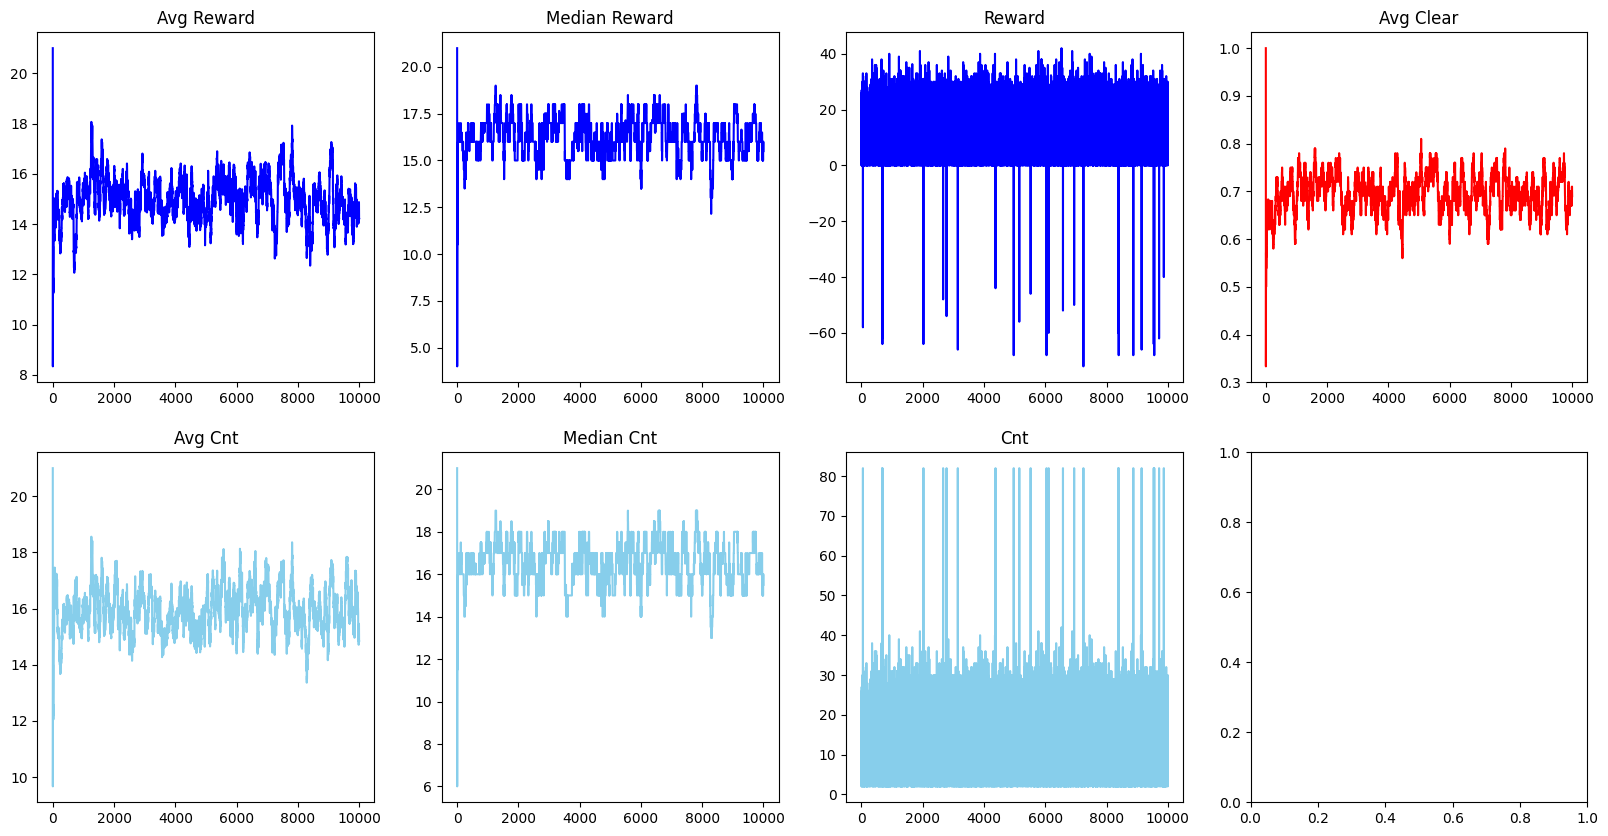

In [ ]:
test_visualizing('experiment8_visualizing_test2.pkl')